In [1]:
import os
import sys
import logging
import torch
import transformers
from datasets import load_dataset

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, 'src'))

logging.basicConfig(level=logging.INFO)

In [2]:
# Load imagenet 1k
dataset = load_dataset("imagenet-1k", split="train[:2000]", cache_dir="/bigdata/cache/huggingface")
# Filter the dataset and only take 3-channel images, images are PIL images
dataset = dataset.filter(lambda x: x['image'].mode == 'RGB')
batch_size = 128

In [3]:
# Get a pretrained VIT with intermediate features
from transformers import AutoProcessor, AutoModel, ViTFeatureExtractor
feature_extractor = transformers.ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', cache_dir='/bigdata/cache/models')
trained_vit = transformers.ViTModel.from_pretrained(
    'google/vit-base-patch16-224-in21k', return_dict=True, output_attentions=True, output_hidden_states=True, cache_dir='/bigdata/cache/models'
)

In [4]:
def preprocess(examples):
    # take a list of PIL images and turn them to pixel values
    images = examples['image']
    inputs = feature_extractor(images=images, return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

# preprocess the dataset by calling map function, but do it one by one
prepared_train = dataset.map(preprocess, batched=True, batch_size=batch_size).with_format('torch')

## Test ViT/Attnention

In [7]:
from gnn_models import CustomAttention
import torch.nn as nn


device = 'cuda'
untrained_vit = transformers.ViTModel(
    config=trained_vit.config,
    add_pooling_layer=True,
    use_mask_token=False,
)
untrained_vit.eval()
trained_vit.eval()
# cls_token = untrained_vit.embeddings.cls_token
d_model = untrained_vit.config.hidden_size
att_layer = CustomAttention(
    embed_dim=d_model, num_heads=1, batch_first=True,
    dv=d_model, do=d_model,
    linear_attention=False
)
att_layer.eval()
before_att_ln = nn.LayerNorm(d_model, elementwise_affine=False)

trained_vit = trained_vit.to(device)
untrained_vit = untrained_vit.to(device)
before_att_ln = before_att_ln.to(device)
att_layer = att_layer.to(device)

In [8]:
def process_embeddings(inputs):
    pixel_values = inputs['pixel_values'].to(device)
    embeddings = untrained_vit.embeddings(pixel_values=pixel_values)
    n = embeddings.size(1)

    rand_vit_outputs = untrained_vit(pixel_values=pixel_values, output_hidden_states=True, return_dict=True)
    trained_vit_outputs = trained_vit(pixel_values=pixel_values, output_hidden_states=True, return_dict=True)

    embeddings_normalized = before_att_ln(embeddings)
    rand_attn_encoded, rand_attn_weights = att_layer(query=embeddings_normalized, key=embeddings_normalized, value=embeddings_normalized, attn_mask=torch.zeros((n, n), dtype=torch.float, device=device))

    inputs['rand_vit_embeddings'] = embeddings.detach().clone().cpu()
    inputs['rand_vit_encoded'] = rand_vit_outputs.hidden_states[1].detach().clone().cpu()
    inputs['trained_vit_encoded'] = trained_vit_outputs.hidden_states[1].detach().clone().cpu()
    inputs['rand_att_encoded'] = inputs['rand_vit_embeddings'] + rand_attn_encoded.detach().clone().cpu()
    inputs['attn_weights'] = rand_attn_weights.detach().clone().cpu()
    return inputs

with torch.no_grad():
    embedded_dataset = prepared_train.map(
        process_embeddings,
        batched=True, batch_size=batch_size
    )

  0%|          | 0/16 [00:00<?, ?ba/s]

In [9]:
from tqdm import tqdm

def get_context_ranks(dataset, key):
    # get the ranks of the context
    ranks = []
    for i in tqdm(range(len(dataset))):
        context = dataset[i][key]
        ranks.append(torch.linalg.matrix_rank(context))
    return torch.tensor(ranks)

In [10]:
rank_dict = {}
for key in ['rand_vit_embeddings', 'rand_vit_encoded', 'rand_att_encoded', 'trained_vit_encoded']:
    rank_dict[key] = get_context_ranks(embedded_dataset, key)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1973/1973 [01:19<00:00, 24.75it/s]


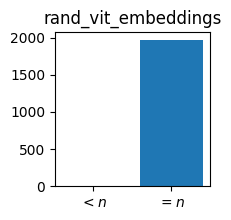

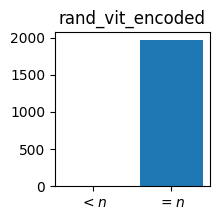

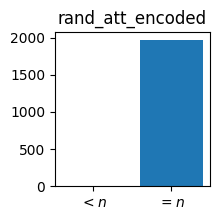

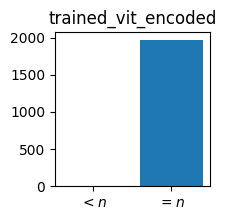

In [11]:
import matplotlib.pyplot as plt

for key, arr in rank_dict.items():
    n = embedded_dataset[0]['rand_vit_embeddings'].shape[0]
    plt.figure(figsize=(2, 2))
    plt.bar(['$<n$', '$=n$'], [sum([r < n for r in arr]), sum([r == n for r in arr])])
    plt.title(key)
    plt.show()


In [32]:
def check_n_kruskal_rank(all_dataset, key, n_rank=None, total_exps=5000, device='cuda'):
    encoded_tensor = all_dataset[key]
    T, n, d = encoded_tensor.shape
    if n_rank is None:
        n_rank = n
    cls_tensor = encoded_tensor[:, 0, :].to(device)
    cnt = 0
    rank_dist = {}
    for _ in tqdm(range(total_exps)):
        # Take a samples of n examples from dataset
        random_perm = torch.randperm(T)[:n_rank]
        sample = cls_tensor[random_perm, :]
        rank = torch.linalg.matrix_rank(sample).item()
        if rank == n_rank:
            cnt += 1
        rank_dist[rank] = rank_dist.get(rank, 0) + 1
    return cnt / total_exps, rank_dist

In [15]:
all_embedded_dataset = embedded_dataset[:]
for key in ['rand_vit_encoded', 'rand_att_encoded', 'trained_vit_encoded', 'rand_vit_embeddings']:
    print(key)
    print(check_n_kruskal_rank(all_embedded_dataset, key))
    print('-' * 20)

rand_vit_encoded


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 354.00it/s]


(1.0, {197: 5000})
--------------------
rand_att_encoded


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 353.07it/s]


(1.0, {197: 5000})
--------------------
trained_vit_encoded


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 354.37it/s]


(0.9982, {197: 4991, 196: 9})
--------------------
rand_vit_embeddings


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:56<00:00, 28.27it/s]


(0.0, {1: 5000})
--------------------


In [16]:
all_embedded_dataset = embedded_dataset[:]
d_data = all_embedded_dataset['rand_vit_embeddings'][0].shape[-1]
print(f"Checking {d_data} Kruskal Rank")
for key in ['rand_vit_encoded', 'rand_att_encoded', 'trained_vit_encoded', 'rand_vit_embeddings']:
    print(key)
    print(check_n_kruskal_rank(all_embedded_dataset, key, n_rank=d_data))
    print('-' * 20)

Checking 768 Kruskal Rank
rand_vit_encoded


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.64it/s]


(0.0, {715: 887, 719: 341, 714: 482, 718: 750, 713: 197, 717: 1060, 716: 1040, 720: 131, 722: 3, 721: 26, 712: 60, 711: 17, 710: 4, 723: 2})
--------------------
rand_att_encoded


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.65it/s]


(0.0, {472: 769, 473: 717, 470: 565, 469: 388, 468: 227, 467: 123, 478: 69, 474: 591, 466: 46, 471: 676, 476: 243, 475: 388, 477: 133, 479: 27, 465: 20, 481: 3, 463: 3, 482: 1, 480: 8, 464: 3})
--------------------
trained_vit_encoded


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:51<00:00, 44.91it/s]


(0.0, {312: 1105, 311: 399, 314: 1178, 310: 97, 313: 1596, 315: 500, 316: 100, 309: 10, 317: 14, 318: 1})
--------------------
rand_vit_embeddings


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:01<00:00, 41.07it/s]

(0.0, {1: 5000})
--------------------


# Check the rank for [1,d]

In [54]:
import numpy as np
from tqdm import tqdm

# all_embedded_dataset = embedded_dataset[:]
# _, n_data, d_data = all_embedded_dataset['rand_vit_embeddings'].shape
# kruskal_dist = {
#     'rand_att_encoded': []
# }
# for key in kruskal_dist:
#     for d in sorted(list(set(range(1, d_datt
#                                    a+1, 10)) | set([n_data, d_data]))):
#         print(f"Checking d={d}")
#         fract, _ = check_n_kruskal_rank(all_embedded_dataset, key, n_rank=d)
#         kruskal_dist['rand_att_encoded'].append((d, fract))
# np.save('kruskal.npy', kruskal_dist)

Checking d=1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4775.74it/s]


Checking d=11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1657.66it/s]


Checking d=21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1225.52it/s]


Checking d=31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1030.83it/s]


Checking d=41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 654.08it/s]


Checking d=51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 575.93it/s]


Checking d=61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 527.44it/s]


Checking d=71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 385.29it/s]


Checking d=81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 359.04it/s]


Checking d=91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 337.78it/s]


Checking d=101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 262.27it/s]


Checking d=111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 248.47it/s]


Checking d=121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 236.55it/s]


Checking d=131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 221.22it/s]


Checking d=141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 216.24it/s]


Checking d=151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 210.41it/s]


Checking d=161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 174.93it/s]


Checking d=171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 169.44it/s]


Checking d=181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 164.99it/s]


Checking d=191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.05it/s]


Checking d=197


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 140.29it/s]


Checking d=201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 139.16it/s]


Checking d=211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.39it/s]


Checking d=221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.09it/s]


Checking d=231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.34it/s]


Checking d=241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.46it/s]


Checking d=251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 113.19it/s]


Checking d=261


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 92.72it/s]


Checking d=271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.34it/s]


Checking d=281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.64it/s]


Checking d=291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 80.71it/s]


Checking d=301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:02<00:00, 79.78it/s]


Checking d=311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:03<00:00, 78.79it/s]


Checking d=321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:08<00:00, 72.64it/s]


Checking d=331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 71.67it/s]


Checking d=341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:10<00:00, 70.97it/s]


Checking d=351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:11<00:00, 70.34it/s]


Checking d=361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:17<00:00, 64.25it/s]


Checking d=371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:18<00:00, 63.64it/s]


Checking d=381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:19<00:00, 63.00it/s]


Checking d=391


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:32<00:00, 53.97it/s]


Checking d=401


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:33<00:00, 53.41it/s]


Checking d=411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:34<00:00, 52.76it/s]


Checking d=421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.80it/s]


Checking d=431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.39it/s]


Checking d=441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.81it/s]


Checking d=451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:51<00:00, 44.99it/s]


Checking d=461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:52<00:00, 44.59it/s]


Checking d=471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:53<00:00, 44.16it/s]


Checking d=481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:00<00:00, 41.45it/s]


Checking d=491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:01<00:00, 41.19it/s]


Checking d=501


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:02<00:00, 40.67it/s]


Checking d=511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:03<00:00, 40.43it/s]


Checking d=521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:23<00:00, 34.95it/s]


Checking d=531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:23<00:00, 34.80it/s]


Checking d=541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:24<00:00, 34.64it/s]


Checking d=551


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:32<00:00, 32.73it/s]


Checking d=561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:33<00:00, 32.58it/s]


Checking d=571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:34<00:00, 32.41it/s]


Checking d=581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:42<00:00, 30.77it/s]


Checking d=591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:43<00:00, 30.59it/s]


Checking d=601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:45<00:00, 30.27it/s]


Checking d=611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:54<00:00, 28.61it/s]


Checking d=621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:56<00:00, 28.35it/s]


Checking d=631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:58<00:00, 27.99it/s]


Checking d=641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:21<00:00, 24.87it/s]


Checking d=651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:22<00:00, 24.71it/s]


Checking d=661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:23<00:00, 24.52it/s]


Checking d=671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:24<00:00, 24.41it/s]


Checking d=681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:34<00:00, 23.29it/s]


Checking d=691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:35<00:00, 23.18it/s]


Checking d=701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:36<00:00, 23.06it/s]


Checking d=711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:46<00:00, 22.03it/s]


Checking d=721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:48<00:00, 21.92it/s]


Checking d=731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:51<00:00, 21.62it/s]


Checking d=741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:02<00:00, 20.61it/s]


Checking d=751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:10<00:00, 19.98it/s]


Checking d=761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:38<00:00, 17.98it/s]


Checking d=768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:34<00:00, 14.96it/s]


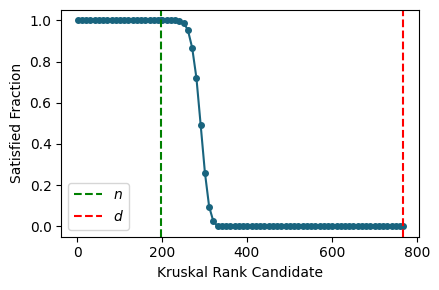

In [96]:
import matplotlib.pyplot as plt
results = np.load('kruskal.npy', allow_pickle=True).item()
translations = {
    'rand_att_encoded': 'Random Attention'
}
plt.figure(figsize=(4.5, 3))
colors = ['#19647e']
for i, key in enumerate(results.keys()):
    x, y = zip(*tuple(results[key]))
    plt.plot(x, y, color=colors[i], marker='.', markersize=8)
plt.axvline(x=n_data, color='g', linestyle='--', label='$n$')
plt.axvline(x=d_data, color='r', linestyle='--', label='$d$')
plt.xlabel('Kruskal Rank Candidate')
plt.ylabel('Satisfied Fraction')
plt.legend()
plt.tight_layout()
plt.savefig('/data/smahdavi/projects/in-context/aux/rand_att_krus_rank.pdf')
plt.show()

In [97]:
print(n_data)

197


In [98]:
print(d_data)

768


# Check Assumption 3

In [106]:
assp3_out = (
    all_embedded_dataset['rand_vit_embeddings'][:, 0, :] + all_embedded_dataset['rand_vit_embeddings'].mean(dim=1)
)

In [112]:
def minimal_check_n_kruskal_rank(arr, n_rank, total_exps=5000, device='cuda'):
    arr = arr.to(device)
    T = arr.shape[0]
    cnt = 0
    rank_dist = {}
    for _ in tqdm(range(total_exps)):
        random_perm = torch.randperm(T)[:n_rank]
        sample = arr[random_perm, :]
        rank = torch.linalg.matrix_rank(sample).item()
        if rank == n_rank:
            cnt += 1
        rank_dist[rank] = rank_dist.get(rank, 0) + 1
    return cnt / total_exps, rank_dist

In [113]:
minimal_check_n_kruskal_rank(assp3_out, n_rank=n_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 140.90it/s]


(1.0, {197: 5000})